## Results

## Training RL agents

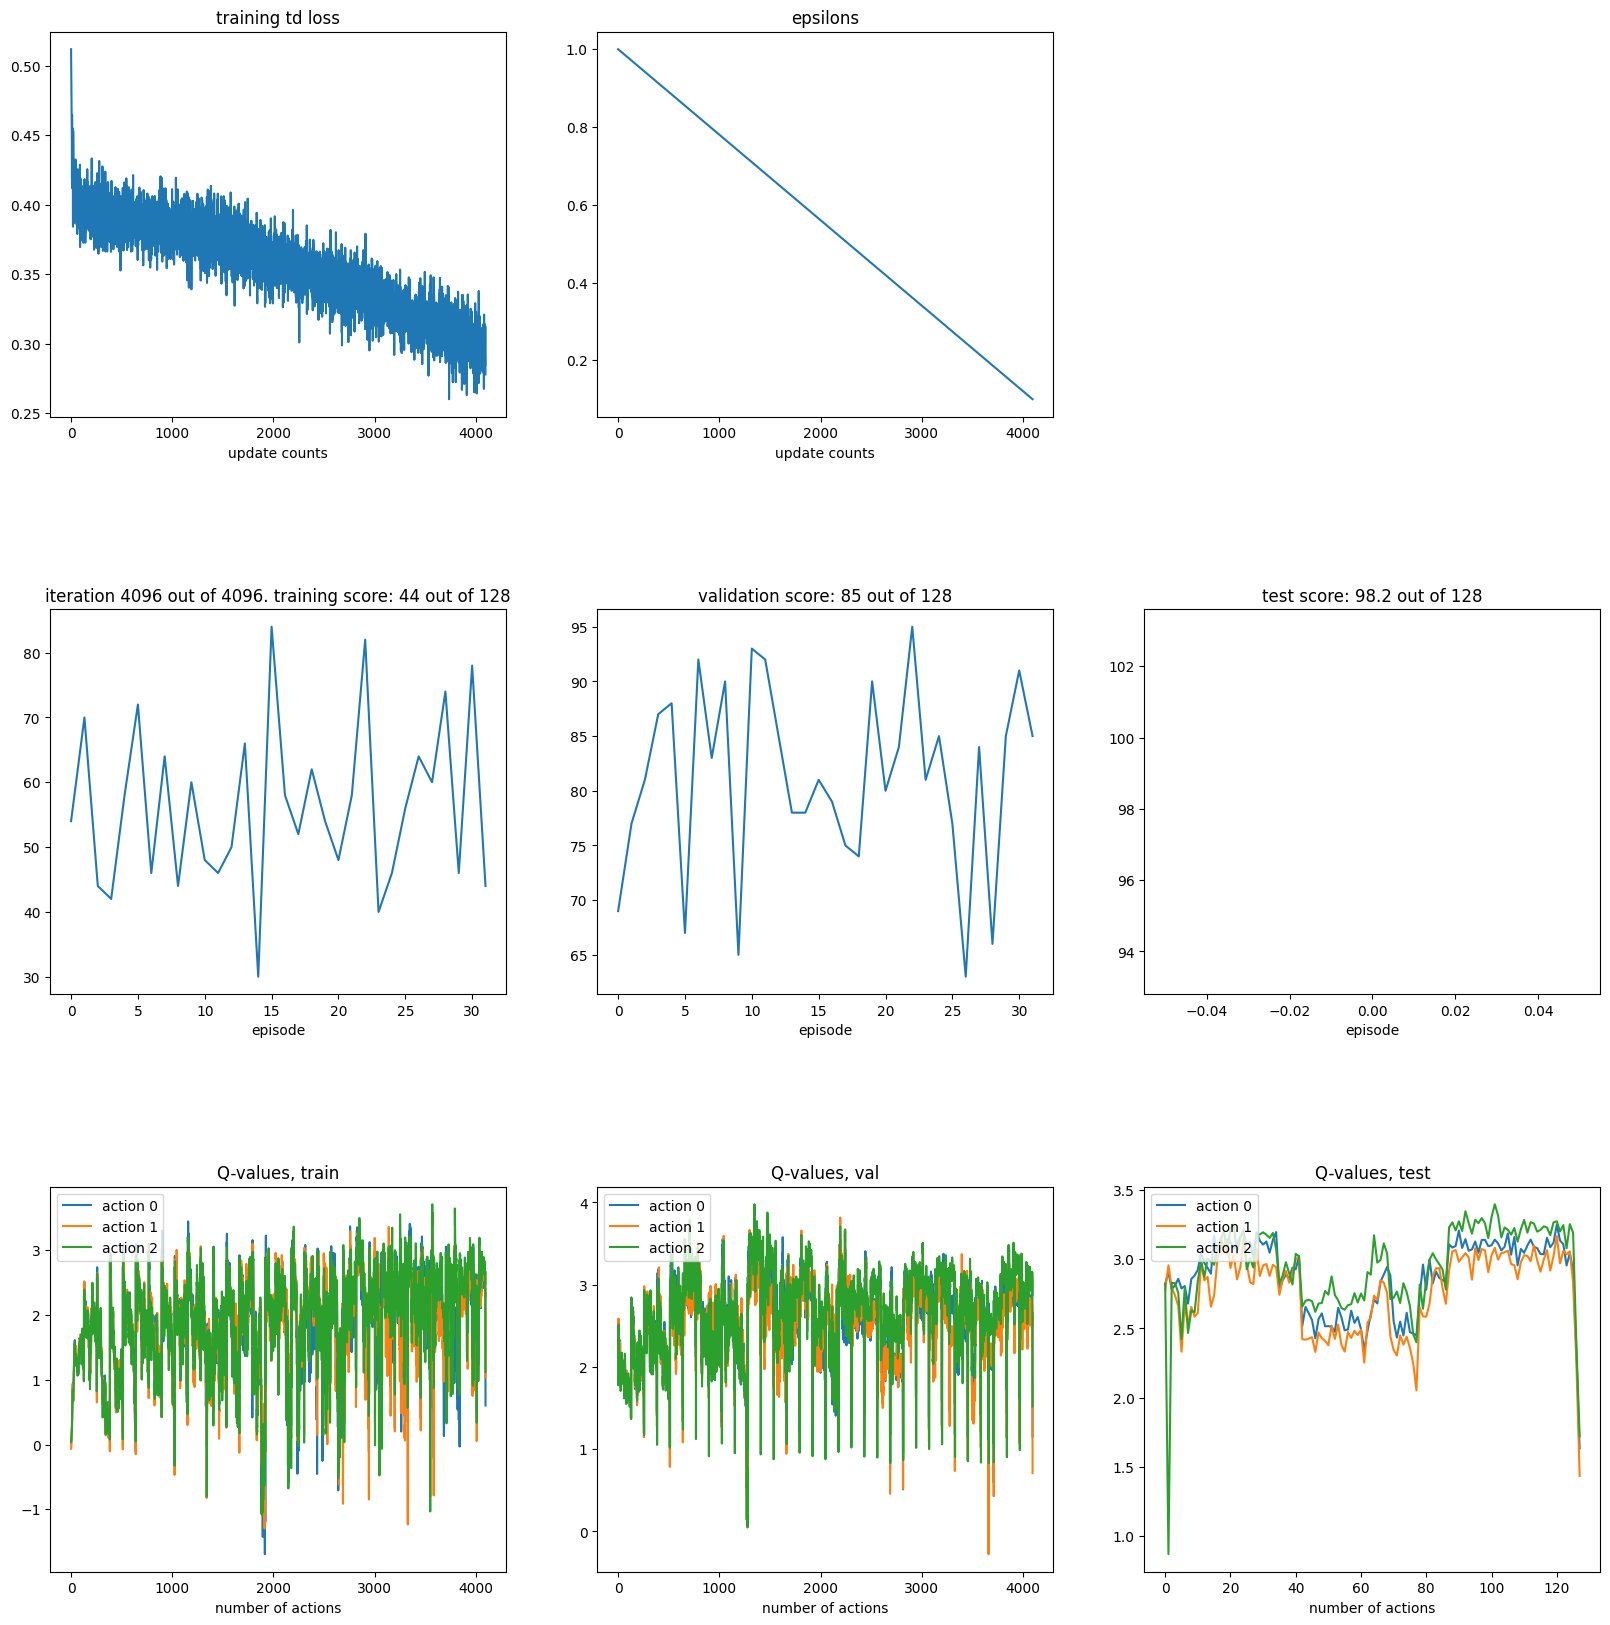

In [1]:
import logging

logger = logging.getLogger()
logger.disabled = True

from agent import DQNAgent

for pretrain_semantic in [True]:
    for test_seed in [3, 4]:
        params = {
            "env_str": "room_env:RoomEnv-v1",
            "env_config": {
                "des_size": "l",
                "question_prob": 1.0,
                "allow_random_human": False,
                "allow_random_question": False,
                "check_resources": True,
            },
            "max_epsilon": 1.0,
            "min_epsilon": 0.1,
            "epsilon_decay_until": 4096,
            "gamma": 0.65,
            "capacity": {"episodic": 16, "semantic": 16, "short": 1},
            "nn_params": {
                "hidden_size": 64,
                "num_layers": 2,
                "embedding_dim": 64,
                "v1_params": {
                    "include_human": "sum",
                    "human_embedding_on_object_location": False,
                },
                "v2_params": None,
                "fuse_information": "sum",
            },
            "num_iterations": 4096,
            "replay_buffer_size": 131072,
            "warm_start": 131072,
            "batch_size": 1024,
            "target_update_interval": 10,
            "pretrain_semantic": pretrain_semantic,
            "run_test": True,
            "num_samples_for_results": 10,
            "train_seed": test_seed + 5,
            "plotting_interval": 10,
            "device": "cpu",
            "test_seed": test_seed,
            "ddqn": False,
            "dueling_dqn": False,
            "default_root_dir": "./training_results/fuse-information=sum/",
        }

        agent = DQNAgent(**params)
        agent.train()

## Testing hand-crafted agents

In [ ]:
import logging

logger = logging.getLogger()
logger.disabled = True

import numpy as np

from tqdm.auto import tqdm

from agent import HandcraftedAgent

for policy in tqdm(["random", "episodic_only", "semantic_only"]):
    results = []
    for test_seed in [0, 1, 2, 3, 4]:
        params = {
            "env_config": {
                "des_size": "l",
                "question_prob": 1.0,
                "allow_random_human": True,
                "allow_random_question": True,
                "check_resources": True,
                "seed": test_seed,
            },
            "env_str": "room_env:RoomEnv-v1",
            "policy": policy,
            "num_samples_for_results": 10,
            "pretrain_semantic": False,
            "default_root_dir": "./training_results/TRASH/",
        }
        if policy == "random":
            params["capacity"] = {"episodic": 16, "semantic": 16, "short": 1}
        elif policy == "episodic_only":
            params["capacity"] = {"episodic": 32, "semantic": 0, "short": 1}
        else:
            params["capacity"] = {"episodic": 0, "semantic": 32, "short": 1}

        agent = HandcraftedAgent(**params)
        agent.test()
        agent.remove_results_from_disk()

        results.append(np.mean(agent.scores))
    print(policy, np.mean(results), np.std(results))